In [ ]:
import numpy as np
from numpy.linalg import norm
import imageio
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms as T
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import sklearn.metrics as metrics

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2a: Finish implementing dataset class

In [ ]:
from torch.nn.functional import normalize
from torchvision.transforms import ToTensor, Compose
from torchvision.transforms.functional import hflip
from torchvision.transforms import RandomHorizontalFlip, RandomAffine, ColorJitter

In [ ]:
class CIFARDataset(Dataset):
  def __init__(self, images, labels, mode, transform):
    self.transform = transform
    self.mode = mode

    if mode == 'train':
      self.images = images[:40000]
      self.labels = labels[:40000]
      # Your code here. If training, use the first 40,000 examples of the 
      # entire dataset 

    elif mode == 'val':
      self.images = images[40000:50000]
      self.labels = labels[40000:50000]
      # Your code here. If validation, use examples 40,000-50,000
      # of the entire dataset 
       
    elif mode == 'test':
      self.images = images[50000:60000]
      self.labels = labels[50000:60000]
      # Your code here. If testing, use examples 50,000-60,000 of the 
      # entire dataset 
      
    else:
      raise ValueError('Invalid mode!')

  def __getitem__(self, idx):
    # Do the following:
    # 1. Get the image and label from the dataset corresponding to index idx.]
    x, y = self.images[idx], self.labels[idx, ...]
    # 2. Convert the label to a LongTensor (needs to be of this type because it 
    # is an integer value and PyTorch will throw an error otherwise)
    label = torch.LongTensor(y)
    # 3. Transform the image using self.transform. This will convert the image 
    # into a tensor, scale it to [0,1], and apply data augmentations.
    image = self.transform(x)
    # # 4. Return the image and label.   
    return image, label

  def __len__(self):
    return len(self.labels) # Replace with your code.

2b: Write transforms

In [ ]:
cifar = np.load('/content/drive/MyDrive/Comp 546: Computer Vision/CIFAR.npz')
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print("Read in CIFAR10 dataset with %d examples, and labels:\n %s" % (X.shape[0], label_names))

batch_size = 64
# RandomHorizontalFlip
transform = Compose([ToTensor(), 
                     RandomHorizontalFlip(-5), # RandomHorizontalFlip
                     RandomAffine(0.8),        # RandomAffine
                     ColorJitter(brightness=0.8, saturation=0.8)]) # ColorJitter()
train_dataset = CIFARDataset(X, y, "train", transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

"""No Augmentation"""
transform = Compose([ToTensor()]) # No augmentations, but should still include ToTensor().
val_dataset = CIFARDataset(X, y, "val", transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = Compose([ToTensor()])# No augmentations, but should still include ToTensor().
test_dataset = CIFARDataset(X, y, "test", transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Read in CIFAR10 dataset with 60000 examples, and labels:
 ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


2c: Implement the model

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 50, kernel_size=(3,3), padding=1), 
        nn.ReLU(),
        )
    self.conv2 = nn.Sequential(
        nn.Conv2d(50, 100, kernel_size=(3,3), padding=1), 
        nn.ReLU(),
        )
    self.conv3 = nn.Sequential(
        nn.Conv2d(100, 100, kernel_size=(3,3), padding=1), 
        nn.ReLU(),
        )
    self.conv4 = nn.Sequential(
        nn.Conv2d(100, 100, kernel_size=(3,3), padding=1), 
        nn.ReLU(),
        )
    self.linear_relu = nn.Sequential(
        nn.Linear(1600,100),
        nn.ReLU(),
    )
    self.linear = nn.Sequential(
        nn.Linear(100, 10)
    )
    self.maxpool1 = nn.MaxPool2d((2,2))
    self.maxpool2 = nn.MaxPool2d((2,2))
    self.maxpool3 = nn.MaxPool2d((2,2))
    
    #Replace with your code
    
  def forward(self, x):
    out1 = self.maxpool1(self.conv1(x))
    out2 = self.maxpool2(self.conv2(out1))
    out3 = self.maxpool3(self.conv3(out2))
    out4 = self.conv4(out3) # error
    out_reshape = out4.reshape(out4.shape[0], out4.shape[1]*out4.shape[2]*out4.shape[3])
    out5 = self.linear_relu(out_reshape)
    out6 = self.linear(out5)
    return out6 #Replace with your code

2d/2e: Implement the training loop, and train your model.

In [ ]:
def save_model(model, loss, epochs, optimizer):
  """Save model checkpoint"""
  # Additional information
  EPOCH = epochs
  PATH = "/content/drive/MyDrive/Comp 546: Computer Vision/best_conv_model.pt"
  LOSS = loss
  torch.save({
              'epoch': EPOCH,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': LOSS,
              }, PATH)
def train_loop(dataloader, model, loss_fn, optimizer, old_loss, epochs, device):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)
      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
      if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        if loss < old_loss:
          save_model(model, loss, epochs, optimizer)
          old_loss = loss
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def get_loss(dataloader, model, loss_fn):
  batch, (X,y) = next(enumerate(dataloader))
  X,y = X.to(device), y.to(device)
  loss = loss_fn(model(X), y)
  return float(loss.cpu())
def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          X,y = X.to(device), y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
# Your code here. Don't forget to call model.eval() first!
"""hyperparameters"""
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
learning_rate = 1e-4
batch_size = 64
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

model = Model()
model = model.to(device)
optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 35

model.eval()
"""No Transformations"""
# cifar = np.load('/content/drive/MyDrive/Comp 546: Computer Vision/CIFAR.npz')
# X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
# transform = Compose([ToTensor()]) 
# train_dataset = CIFARDataset(X, y, "train", transform)
# train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

old_loss = 10
loss_arr = []
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, old_loss, epochs, device)
    test_loop(test_dataloader, model, loss_fn, device)
    loss_arr.append(get_loss(train_dataloader, model, loss_fn))
print("Done!")

Using cuda device


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 2.310559  [   64/40000]
loss: 2.211158  [ 6464/40000]
loss: 1.999919  [12864/40000]
loss: 1.937987  [19264/40000]
loss: 1.775382  [25664/40000]
loss: 1.777660  [32064/40000]
loss: 1.714833  [38464/40000]
Test Error: 
 Accuracy: 37.1%, Avg loss: 1.737099 



  3%|▎         | 1/35 [00:38<21:36, 38.13s/it]

Epoch 2
-------------------------------
loss: 1.795341  [   64/40000]
loss: 1.798133  [ 6464/40000]
loss: 1.852061  [12864/40000]
loss: 1.960701  [19264/40000]
loss: 1.777744  [25664/40000]
loss: 1.759110  [32064/40000]
loss: 1.550747  [38464/40000]
Test Error: 
 Accuracy: 42.6%, Avg loss: 1.580845 



  6%|▌         | 2/35 [01:17<21:16, 38.68s/it]

Epoch 3
-------------------------------
loss: 1.574423  [   64/40000]
loss: 1.602225  [ 6464/40000]
loss: 1.796669  [12864/40000]
loss: 1.872867  [19264/40000]
loss: 1.656806  [25664/40000]
loss: 1.659509  [32064/40000]
loss: 1.507502  [38464/40000]
Test Error: 
 Accuracy: 44.5%, Avg loss: 1.510133 



  9%|▊         | 3/35 [01:56<20:42, 38.82s/it]

Epoch 4
-------------------------------
loss: 1.403736  [   64/40000]
loss: 1.590931  [ 6464/40000]
loss: 1.358823  [12864/40000]
loss: 1.475272  [19264/40000]
loss: 1.567592  [25664/40000]
loss: 1.401840  [32064/40000]
loss: 1.539596  [38464/40000]
Test Error: 
 Accuracy: 46.5%, Avg loss: 1.479986 



 11%|█▏        | 4/35 [02:35<20:03, 38.84s/it]

Epoch 5
-------------------------------
loss: 1.460836  [   64/40000]
loss: 1.454331  [ 6464/40000]
loss: 1.501349  [12864/40000]
loss: 1.609301  [19264/40000]
loss: 1.425179  [25664/40000]
loss: 1.612624  [32064/40000]
loss: 1.782388  [38464/40000]
Test Error: 
 Accuracy: 49.4%, Avg loss: 1.389259 



 14%|█▍        | 5/35 [03:13<19:23, 38.79s/it]

Epoch 6
-------------------------------
loss: 1.381146  [   64/40000]
loss: 1.423729  [ 6464/40000]
loss: 1.448473  [12864/40000]
loss: 1.230870  [19264/40000]
loss: 1.372405  [25664/40000]
loss: 1.426040  [32064/40000]
loss: 1.433333  [38464/40000]
Test Error: 
 Accuracy: 51.2%, Avg loss: 1.348613 



 17%|█▋        | 6/35 [03:50<18:24, 38.09s/it]

Epoch 7
-------------------------------
loss: 1.515237  [   64/40000]
loss: 1.238201  [ 6464/40000]
loss: 1.223456  [12864/40000]
loss: 1.448035  [19264/40000]
loss: 1.386130  [25664/40000]
loss: 1.451475  [32064/40000]
loss: 1.393560  [38464/40000]
Test Error: 
 Accuracy: 52.1%, Avg loss: 1.318475 



 20%|██        | 7/35 [04:28<17:47, 38.12s/it]

Epoch 8
-------------------------------
loss: 1.451147  [   64/40000]
loss: 1.475711  [ 6464/40000]
loss: 1.388307  [12864/40000]
loss: 1.309713  [19264/40000]
loss: 1.513996  [25664/40000]
loss: 1.322297  [32064/40000]
loss: 1.457168  [38464/40000]
Test Error: 
 Accuracy: 55.1%, Avg loss: 1.263762 



 23%|██▎       | 8/35 [05:07<17:14, 38.32s/it]

Epoch 9
-------------------------------
loss: 1.655016  [   64/40000]
loss: 1.393899  [ 6464/40000]
loss: 1.191969  [12864/40000]
loss: 1.224261  [19264/40000]
loss: 1.179124  [25664/40000]
loss: 1.321343  [32064/40000]
loss: 1.389765  [38464/40000]
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.252526 



 26%|██▌       | 9/35 [05:45<16:37, 38.37s/it]

Epoch 10
-------------------------------
loss: 1.331673  [   64/40000]
loss: 1.040754  [ 6464/40000]
loss: 1.276440  [12864/40000]
loss: 1.216743  [19264/40000]
loss: 1.151013  [25664/40000]
loss: 1.390028  [32064/40000]
loss: 1.481268  [38464/40000]
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.229812 



 29%|██▊       | 10/35 [06:23<15:55, 38.23s/it]

Epoch 11
-------------------------------
loss: 1.231100  [   64/40000]
loss: 1.178529  [ 6464/40000]
loss: 1.060283  [12864/40000]
loss: 1.301437  [19264/40000]
loss: 1.364391  [25664/40000]
loss: 1.294926  [32064/40000]
loss: 1.247358  [38464/40000]
Test Error: 
 Accuracy: 58.1%, Avg loss: 1.168463 



 31%|███▏      | 11/35 [07:01<15:17, 38.22s/it]

Epoch 12
-------------------------------
loss: 1.005561  [   64/40000]
loss: 1.078626  [ 6464/40000]
loss: 1.294371  [12864/40000]
loss: 1.142838  [19264/40000]
loss: 1.117437  [25664/40000]
loss: 1.285864  [32064/40000]
loss: 1.334867  [38464/40000]
Test Error: 
 Accuracy: 58.5%, Avg loss: 1.159104 



 34%|███▍      | 12/35 [07:40<14:37, 38.16s/it]

Epoch 13
-------------------------------
loss: 1.038528  [   64/40000]
loss: 1.176571  [ 6464/40000]
loss: 0.905920  [12864/40000]
loss: 1.067066  [19264/40000]
loss: 1.161308  [25664/40000]
loss: 1.153205  [32064/40000]
loss: 1.286935  [38464/40000]
Test Error: 
 Accuracy: 60.6%, Avg loss: 1.105245 



 37%|███▋      | 13/35 [08:18<14:00, 38.21s/it]

Epoch 14
-------------------------------
loss: 1.176626  [   64/40000]
loss: 0.983227  [ 6464/40000]
loss: 1.278403  [12864/40000]
loss: 1.227532  [19264/40000]
loss: 1.159063  [25664/40000]
loss: 1.272055  [32064/40000]
loss: 1.109298  [38464/40000]
Test Error: 
 Accuracy: 60.7%, Avg loss: 1.115408 



 40%|████      | 14/35 [08:56<13:23, 38.27s/it]

Epoch 15
-------------------------------
loss: 1.225438  [   64/40000]
loss: 1.264673  [ 6464/40000]
loss: 0.867236  [12864/40000]
loss: 1.198090  [19264/40000]
loss: 1.206507  [25664/40000]
loss: 1.166115  [32064/40000]
loss: 1.136275  [38464/40000]
Test Error: 
 Accuracy: 61.4%, Avg loss: 1.083151 



 43%|████▎     | 15/35 [09:35<12:50, 38.55s/it]

Epoch 16
-------------------------------
loss: 1.194355  [   64/40000]
loss: 1.075249  [ 6464/40000]
loss: 1.196666  [12864/40000]
loss: 1.074770  [19264/40000]
loss: 1.324235  [25664/40000]
loss: 0.956403  [32064/40000]
loss: 1.323692  [38464/40000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.146906 



 46%|████▌     | 16/35 [10:16<12:21, 39.00s/it]

Epoch 17
-------------------------------
loss: 1.308831  [   64/40000]
loss: 0.756429  [ 6464/40000]
loss: 1.073729  [12864/40000]
loss: 1.124503  [19264/40000]
loss: 0.974531  [25664/40000]
loss: 0.954030  [32064/40000]
loss: 0.975517  [38464/40000]
Test Error: 
 Accuracy: 63.4%, Avg loss: 1.030046 



 49%|████▊     | 17/35 [10:55<11:47, 39.29s/it]

Epoch 18
-------------------------------
loss: 1.134220  [   64/40000]
loss: 1.431633  [ 6464/40000]
loss: 1.146652  [12864/40000]
loss: 1.217580  [19264/40000]
loss: 1.004583  [25664/40000]
loss: 0.923435  [32064/40000]
loss: 1.215586  [38464/40000]
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.043211 



 51%|█████▏    | 18/35 [11:34<11:04, 39.11s/it]

Epoch 19
-------------------------------
loss: 0.926939  [   64/40000]
loss: 1.107207  [ 6464/40000]
loss: 1.153369  [12864/40000]
loss: 1.367417  [19264/40000]
loss: 0.983731  [25664/40000]
loss: 1.130128  [32064/40000]
loss: 0.961987  [38464/40000]
Test Error: 
 Accuracy: 63.9%, Avg loss: 1.019671 



 54%|█████▍    | 19/35 [12:13<10:22, 38.91s/it]

Epoch 20
-------------------------------
loss: 0.897034  [   64/40000]
loss: 1.151656  [ 6464/40000]
loss: 1.031472  [12864/40000]
loss: 0.776916  [19264/40000]
loss: 0.880384  [25664/40000]
loss: 1.042806  [32064/40000]
loss: 0.923877  [38464/40000]
Test Error: 
 Accuracy: 65.2%, Avg loss: 0.982084 



 57%|█████▋    | 20/35 [12:52<09:43, 38.91s/it]

Epoch 21
-------------------------------
loss: 0.925279  [   64/40000]
loss: 1.046754  [ 6464/40000]
loss: 0.956324  [12864/40000]
loss: 1.132171  [19264/40000]
loss: 0.820261  [25664/40000]
loss: 0.897375  [32064/40000]
loss: 1.107933  [38464/40000]
Test Error: 
 Accuracy: 64.4%, Avg loss: 1.007031 



 60%|██████    | 21/35 [13:31<09:05, 38.93s/it]

Epoch 22
-------------------------------
loss: 1.068496  [   64/40000]
loss: 0.910324  [ 6464/40000]
loss: 0.984518  [12864/40000]
loss: 0.925988  [19264/40000]
loss: 0.902755  [25664/40000]
loss: 0.944610  [32064/40000]
loss: 0.886561  [38464/40000]
Test Error: 
 Accuracy: 66.1%, Avg loss: 0.961588 



 63%|██████▎   | 22/35 [14:10<08:27, 39.02s/it]

Epoch 23
-------------------------------
loss: 0.903597  [   64/40000]
loss: 0.631510  [ 6464/40000]
loss: 0.855774  [12864/40000]
loss: 1.057953  [19264/40000]
loss: 1.170961  [25664/40000]
loss: 0.926439  [32064/40000]
loss: 1.188358  [38464/40000]
Test Error: 
 Accuracy: 66.3%, Avg loss: 0.964887 



 66%|██████▌   | 23/35 [14:47<07:42, 38.53s/it]

Epoch 24
-------------------------------
loss: 0.951985  [   64/40000]
loss: 0.747930  [ 6464/40000]
loss: 0.984950  [12864/40000]
loss: 0.905007  [19264/40000]
loss: 1.102623  [25664/40000]
loss: 0.943626  [32064/40000]
loss: 0.969591  [38464/40000]
Test Error: 
 Accuracy: 67.7%, Avg loss: 0.931690 



 69%|██████▊   | 24/35 [15:25<07:02, 38.45s/it]

Epoch 25
-------------------------------
loss: 1.094249  [   64/40000]
loss: 0.983379  [ 6464/40000]
loss: 0.884930  [12864/40000]
loss: 0.998478  [19264/40000]
loss: 0.864110  [25664/40000]
loss: 0.679782  [32064/40000]
loss: 0.868951  [38464/40000]
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.918584 



 71%|███████▏  | 25/35 [16:04<06:26, 38.62s/it]

Epoch 26
-------------------------------
loss: 0.964505  [   64/40000]
loss: 0.893470  [ 6464/40000]
loss: 0.940629  [12864/40000]
loss: 1.097514  [19264/40000]
loss: 0.670862  [25664/40000]
loss: 0.676821  [32064/40000]
loss: 0.833660  [38464/40000]
Test Error: 
 Accuracy: 68.2%, Avg loss: 0.909946 



 74%|███████▍  | 26/35 [16:43<05:46, 38.47s/it]

Epoch 27
-------------------------------
loss: 0.888680  [   64/40000]
loss: 0.682955  [ 6464/40000]
loss: 1.116056  [12864/40000]
loss: 0.871003  [19264/40000]
loss: 0.987651  [25664/40000]
loss: 1.083247  [32064/40000]
loss: 1.095437  [38464/40000]
Test Error: 
 Accuracy: 68.1%, Avg loss: 0.911768 



 77%|███████▋  | 27/35 [17:20<05:05, 38.21s/it]

Epoch 28
-------------------------------
loss: 0.885445  [   64/40000]
loss: 0.861999  [ 6464/40000]
loss: 0.727441  [12864/40000]
loss: 0.904598  [19264/40000]
loss: 0.834836  [25664/40000]
loss: 0.978571  [32064/40000]
loss: 0.964512  [38464/40000]
Test Error: 
 Accuracy: 69.5%, Avg loss: 0.892367 



 80%|████████  | 28/35 [17:58<04:27, 38.19s/it]

Epoch 29
-------------------------------
loss: 1.148264  [   64/40000]
loss: 0.874036  [ 6464/40000]
loss: 0.751805  [12864/40000]
loss: 0.664394  [19264/40000]
loss: 0.945214  [25664/40000]
loss: 0.870648  [32064/40000]
loss: 0.680281  [38464/40000]
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.916956 



 83%|████████▎ | 29/35 [18:36<03:49, 38.20s/it]

Epoch 30
-------------------------------
loss: 1.018469  [   64/40000]
loss: 0.598195  [ 6464/40000]
loss: 0.809545  [12864/40000]
loss: 0.967932  [19264/40000]
loss: 0.874563  [25664/40000]
loss: 0.809511  [32064/40000]
loss: 0.947901  [38464/40000]
Test Error: 
 Accuracy: 70.0%, Avg loss: 0.866961 



 86%|████████▌ | 30/35 [19:15<03:11, 38.22s/it]

Epoch 31
-------------------------------
loss: 0.804454  [   64/40000]
loss: 0.996149  [ 6464/40000]
loss: 0.788831  [12864/40000]
loss: 0.744761  [19264/40000]
loss: 0.812140  [25664/40000]
loss: 0.721795  [32064/40000]
loss: 0.685957  [38464/40000]
Test Error: 
 Accuracy: 70.3%, Avg loss: 0.847417 



 89%|████████▊ | 31/35 [19:52<02:32, 38.00s/it]

Epoch 32
-------------------------------
loss: 0.732063  [   64/40000]
loss: 0.762691  [ 6464/40000]
loss: 0.682572  [12864/40000]
loss: 0.640653  [19264/40000]
loss: 0.930178  [25664/40000]
loss: 0.606978  [32064/40000]
loss: 0.790472  [38464/40000]
Test Error: 
 Accuracy: 70.3%, Avg loss: 0.859658 



 91%|█████████▏| 32/35 [20:30<01:54, 38.02s/it]

Epoch 33
-------------------------------
loss: 0.772020  [   64/40000]
loss: 0.979933  [ 6464/40000]
loss: 0.776141  [12864/40000]
loss: 0.660359  [19264/40000]
loss: 0.945482  [25664/40000]
loss: 0.858433  [32064/40000]
loss: 0.740915  [38464/40000]
Test Error: 
 Accuracy: 70.6%, Avg loss: 0.848243 



 94%|█████████▍| 33/35 [21:09<01:16, 38.17s/it]

Epoch 34
-------------------------------
loss: 0.795180  [   64/40000]
loss: 0.710734  [ 6464/40000]
loss: 0.638241  [12864/40000]
loss: 0.678707  [19264/40000]
loss: 0.747760  [25664/40000]
loss: 0.754507  [32064/40000]
loss: 0.809057  [38464/40000]
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.842694 



 97%|█████████▋| 34/35 [21:47<00:38, 38.08s/it]

Epoch 35
-------------------------------
loss: 0.882530  [   64/40000]
loss: 0.732297  [ 6464/40000]
loss: 0.652557  [12864/40000]
loss: 0.798177  [19264/40000]
loss: 0.716690  [25664/40000]
loss: 0.827238  [32064/40000]
loss: 0.867802  [38464/40000]
Test Error: 
 Accuracy: 70.4%, Avg loss: 0.866906 



100%|██████████| 35/35 [22:25<00:00, 38.45s/it]

Done!


Text(0, 0.5, 'loss')

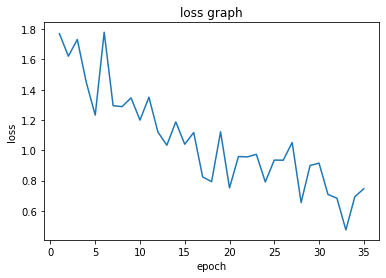

In [ ]:
plt.plot(list(np.arange(1,36)),loss_arr,) 
#set title and x, y - axes labels
plt.title('loss graph')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
"""Save model checkpoint"""
# # Additional information
# EPOCH = epochs
PATH = "/content/drive/MyDrive/Comp 546: Computer Vision/best_conv_model.pt"
# LOSS = 1.245

# torch.save({
#             'epoch': EPOCH,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS,
#             }, PATH)

In [ ]:
loaded_model = Model()
optimizer = torch.optim.SGD(loaded_model.parameters(), lr=learning_rate)

checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

NameError: ignored

2f: Choose the best model based on overall accuracy 
using the validation dataset.

In [ ]:
def evaluation(labels_dict, total_dict, cf, labels, preds, y):
  for val in range(len(preds)):
    if(np.argmax(preds[val]) == y[val]):
      labels_dict[labels[y[val]]] += 1
    
    """Extend confusin matrix values"""
    y_pred, y_true = labels[np.argmax(preds[val])], labels[y[val]]
    cf[0].append(y_pred) # extend pred values
    cf[1].append(y_true) # extend true values
    
    """increase total number of predictions"""
    total_dict[y_true] += 1

  return labels_dict, total_dict

In [ ]:
def test_loop(dataloader, model, loss_fn, label_names):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    """Create dictionary to track accuracy per class"""
    labels_dict, total_dict, cf = dict(), dict(), [[],[]]
    for label in label_names:
      labels_dict[label],total_dict[label] = 0, 0

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            label_dict, total_dict = evaluation(labels_dict, total_dict, cf, label_names, pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        """Get 5-10 examples of mistakes model made"""
        count, images, indice, correct_label, incorrect = 0, [], [], [], []
        for X, y in tqdm(dataloader):
          if(count == 10):
            break
          pred = model(X)
          for val in range(len(pred)):
            if(np.argmax(pred[val]) != y[val] and y[val] == 3):
              images.append(X)
              indice.append(val)
              correct_label.append(label_names[y[val]])
              incorrect.append(label_names[np.argmax(pred[val])])
              count += 1
          

    test_loss /= num_batches
    correct /= size

    """create confusion matrix"""
    confusion_matrix = metrics.confusion_matrix(cf[1], cf[0])
    
    for label in label_names:
      labels_dict[label] = f'{labels_dict[label]/total_dict[label]*100:>0.1f}'
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return labels_dict, confusion_matrix, images, indice, correct_label, incorrect

2g: Implement code for computing overall accuracy, accuracy per class, and the confusion matrix on the test set.

In [ ]:
class_acc, confusion_matrix, images, indice, correct_label, pred = test_loop(test_dataloader, loaded_model, loss_fn, label_names)

In [ ]:
print(f"Accuracy per class: {class_acc}")

In [ ]:
df = pd.DataFrame(data=class_acc)
df

### According to this accuracy metric listed above, 'cat' was the class which this model had the worst accuracy of 34%

### According to the confusion matrix, the model confused a 'cat' image with a 'dog' the most.

In [ ]:
import pandas as pd
# creating a 2 dimensional dataframe out of the given data
df = pd.DataFrame(data=confusion_matrix,columns=label_names)
df.index = label_names
df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,777,8,46,10,19,6,7,16,65,46
automobile,24,779,6,4,3,3,10,10,23,138
bird,94,3,593,39,101,53,36,52,13,16
cat,31,11,98,428,80,173,67,79,14,19
deer,32,3,61,38,668,26,37,122,11,2
dog,16,1,89,144,41,580,14,93,11,11
frog,9,3,64,54,68,27,741,12,9,13
horse,13,1,27,24,43,43,2,828,1,18
ship,83,29,9,9,9,4,4,9,810,34
truck,32,58,7,11,2,6,7,22,34,821


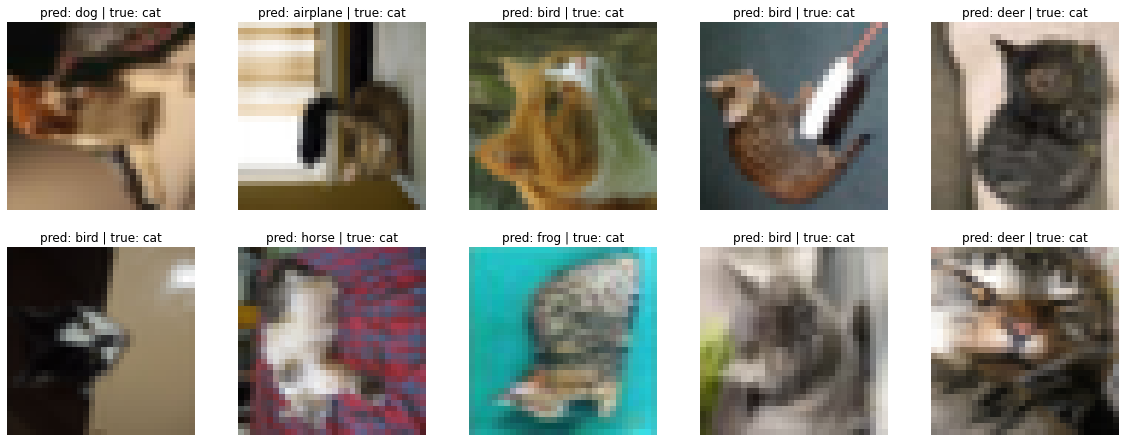

In [ ]:
""" 
g. iv: For the class on which your model has the worst accuracy (part ii), what is
the other class it is most confused with? Show 5-10 test images that your
model confused between these classes and comment on what factors
may have caused the poor performance. 
"""
# create figure
fig = plt.figure(figsize=(20, 20))
# setting values to rows and column variables
rows,columns = 5,5
# Adds a subplot at the 1st position
for val in range(10):
  # Add image to plot
  fig.add_subplot(rows, columns, val+1); plt.imshow(images[val][indice[val]].T)
  plt.axis('off'); plt.title(f"pred: {pred[val]} | true: {correct_label[val]}")

## Part h:  Change the last two Conv blocks in the architecture to Residual blocks and report overall accuracy of the best model. Recall the form of a residual block:

<img src="/content/drive/MyDrive/Comp 546: Computer Vision/parrot.png" alt="Residual Block" width="200"/>


In [ ]:
def save_model(model, loss, epochs, optimizer):
  """Save model checkpoint"""
  # Additional information
  EPOCH = epochs
  PATH = "/content/drive/MyDrive/Comp 546: Computer Vision/best_model.pt"
  LOSS = loss
  torch.save({
              'epoch': EPOCH,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': LOSS,
              }, PATH)
def train_loop(dataloader, model, loss_fn, optimizer, old_loss, epochs, device):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)
      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
      if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        if loss < old_loss:
          save_model(model, loss, epochs, optimizer)
          old_loss = loss
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          X,y = X.to(device), y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 50, kernel_size=(3,3), padding=1), 
        nn.ReLU(),
        )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(50, 100, kernel_size=(3,3), padding=1), 
        nn.ReLU(),
        )
    # conv_layer3 replaced with residual layer
    self.residual_layer = nn.Sequential(
        nn.Conv2d(100, 100, kernel_size=(3,3), padding=1), 
        nn.ReLU(),
        nn.Conv2d(100, 100, kernel_size=(3,3), padding=1), 
        )
    self.linear_relu = nn.Sequential(
        nn.Linear(1600,100),
        nn.ReLU(),
    )
    self.linear = nn.Sequential(
        nn.Linear(100, 10)
    )
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d((2,2))

  def forward(self, x):
    out1 = self.maxpool(self.conv_layer1(x))
    out2 = self.maxpool(self.conv_layer2(out1))
    out3 = self.maxpool(self.relu(self.residual_layer(out2)+out2)) # residual block 1
    out4 = self.relu(self.residual_layer(out3)+out3) # residual block 2
    out_reshape = out4.reshape(out4.shape[0], out4.shape[1]*out4.shape[2]*out4.shape[3])  # Reshape for linear layers
    out5 = self.linear_relu(out_reshape)
    out6 = self.linear(out5)
    return out6 

In [ ]:
# Your code here. Don't forget to call model.eval() first!
"""hyperparameters"""
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
learning_rate = 1e-4
batch_size = 64
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

model2 = Model()
model2 = model2.to(device)
model2.eval()
optimizer =  torch.optim.Adam(model2.parameters(), lr=learning_rate)
epochs = 35


"""No Transformations"""
cifar = np.load('/content/drive/MyDrive/Comp 546: Computer Vision/CIFAR.npz')
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
transform = Compose([ToTensor()]) 
train_dataset = CIFARDataset(X, y, "train", transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
old_loss = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model2, loss_fn, optimizer, old_loss, epochs, device)
    test_loop(test_dataloader, model2, loss_fn, device)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.297759  [   64/40000]
loss: 2.117565  [ 6464/40000]
loss: 1.968871  [12864/40000]
loss: 1.788198  [19264/40000]
loss: 1.799364  [25664/40000]
loss: 1.720471  [32064/40000]
loss: 1.752448  [38464/40000]
Test Error: 
 Accuracy: 39.4%, Avg loss: 1.649234 

Epoch 2
-------------------------------
loss: 1.493116  [   64/40000]
loss: 1.704365  [ 6464/40000]
loss: 1.562654  [12864/40000]
loss: 1.727576  [19264/40000]
loss: 1.324703  [25664/40000]
loss: 1.796632  [32064/40000]
loss: 1.597469  [38464/40000]
Test Error: 
 Accuracy: 44.9%, Avg loss: 1.500804 

Epoch 3
-------------------------------
loss: 1.548721  [   64/40000]
loss: 1.449976  [ 6464/40000]
loss: 1.558533  [12864/40000]
loss: 1.598846  [19264/40000]
loss: 1.518012  [25664/40000]
loss: 1.362699  [32064/40000]
loss: 1.436214  [38464/40000]
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.417930 

Epoch 4
-------------------------------
loss: 1.278890  [   64/40000]
loss: 

In [ ]:
loaded_model = Model()
optimizer = torch.optim.SGD(loaded_model.parameters(), lr=learning_rate)
PATH = "/content/drive/MyDrive/Comp 546: Computer Vision/best_model.pt"
checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
test_loop(test_dataloader, model2, loss_fn, device)

Test Error: 
 Accuracy: 74.7%, Avg loss: 0.747396 

